<a href="https://colab.research.google.com/github/evinracher/3008410-intelligent-systems/blob/main/week2/exercise1/Translator_with_BLUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Map:   0%|          | 0/14074 [00:00<?, ? examples/s]

Map:   0%|          | 0/6033 [00:00<?, ? examples/s]

Epoch 1/5
879/879 [==============================] - ETA: 0s - loss: 2.2699
📘 Epoch 1 - BLEU Score: 0.1319
879/879 [==============================] - 16049s 18s/step - loss: 2.2699 - val_loss: 1.5359
Epoch 2/5
879/879 [==============================] - ETA: 0s - loss: 1.6145
📘 Epoch 2 - BLEU Score: 0.2161
879/879 [==============================] - 15261s 17s/step - loss: 1.6145 - val_loss: 1.2337
Epoch 3/5
879/879 [==============================] - ETA: 0s - loss: 1.3253
📘 Epoch 3 - BLEU Score: 0.2625
879/879 [==============================] - 14805s 17s/step - loss: 1.3253 - val_loss: 1.0933
Epoch 4/5
879/879 [==============================] - ETA: 0s - loss: 1.1457
📘 Epoch 4 - BLEU Score: 0.2989
879/879 [==============================] - 15013s 17s/step - loss: 1.1457 - val_loss: 0.9972
Epoch 5/5
879/879 [==============================] - ETA: 0s - loss: 1.0192
📘 Epoch 5 - BLEU Score: 0.3125
879/879 [==============================] - 14753s 17s/step - loss: 1.0192 - val_loss: 0.9348


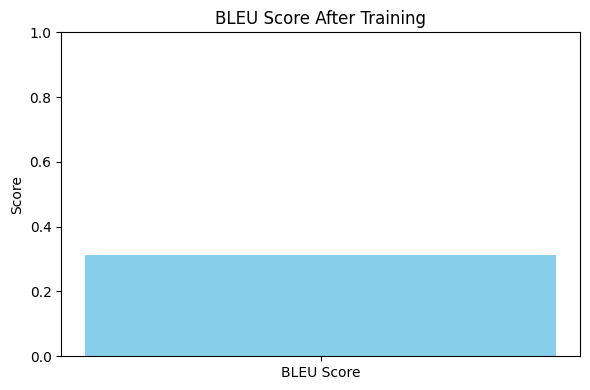

In [ ]:

from transformers import AutoTokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM, AdamWeightDecay, pipeline
from datasets import Dataset
import tensorflow as tf
import evaluate
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
folder_path = r"C:/Users/John/Downloads/Universidad/AI Generativa Course/Exercises/Exercise2"
dataset_name = "eng_small.csv"
path = os.path.join(folder_path, dataset_name)
data = Dataset.from_csv(path, encoding='utf-8')
data = data.train_test_split(test_size=0.3)

# --- Tokenizer & Model ---
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")

# --- Preprocessing ---
prefix = "translate: "
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["engl"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=examples["spa"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data = data.map(preprocess_function, batched=True, remove_columns=["engl", "spa"])

# --- Data Collator ---
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

# --- Prepare TF datasets ---
tf_train_set = model.prepare_tf_dataset(tokenized_data["train"], shuffle=True, batch_size=16, collate_fn=data_collator)
tf_test_set = model.prepare_tf_dataset(tokenized_data["test"], shuffle=False, batch_size=16, collate_fn=data_collator)

# --- Optimizer ---
optimizer = AdamWeightDecay(learning_rate=2e-4, weight_decay_rate=0.01)
model.compile(optimizer=optimizer)  # Use internal loss handling

# --- BLEU Callback ---
bleu = evaluate.load("bleu")
class BLEUCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, tokenizer, raw_dataset):
        self.model = model
        self.tokenizer = tokenizer
        self.raw_dataset = raw_dataset

    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        references = []
        for sample in self.raw_dataset:
            input_text = prefix + sample["engl"]
            reference = sample["spa"]
            inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)
            output = model.generate(**inputs, max_length=128)
            pred = tokenizer.decode(output[0], skip_special_tokens=True)
            predictions.append(pred)
            references.append([reference])
        result = bleu.compute(predictions=predictions, references=references)
        print(f"\n📘 Epoch {epoch+1} - BLEU Score: {round(result['bleu'], 4)}")

# --- Train Model ---
epochs = 5
raw_test_data = data["test"].to_pandas().to_dict(orient='records')
history = model.fit(tf_train_set, validation_data=tf_test_set, epochs=epochs,
                    callbacks=[BLEUCallback(model, tokenizer, raw_test_data)])

# --- Save model ---
model_path = os.path.join('model', f"NMT-epocs-{epochs}")
model.save_pretrained(model_path)

# --- Export Predictions ---
print("Exporting predictions...")
predictions, references, sources = [], [], []
for sample in raw_test_data:
    input_text = prefix + sample["engl"]
    reference = sample["spa"]
    inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)
    output = model.generate(**inputs, max_length=128)
    pred = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(pred)
    references.append(reference)
    sources.append(sample["engl"])

df = pd.DataFrame({
    "Source (EN)": sources,
    "Reference (ES)": references,
    "Prediction": predictions
})
csv_path = os.path.join(folder_path, f"predictions_epoch{epochs}.csv")
df.to_csv(csv_path, index=False)
print(f"Predictions saved to: {csv_path}")

# --- Optional: plot BLEU score summary ---
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])["bleu"]
plt.figure(figsize=(6, 4))
plt.bar(["BLEU Score"], [bleu_score], color='skyblue')
plt.title("BLEU Score After Training")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()


## Exercises

- Try with max_length=512 and report
- Double the epochs = 10 and report
- Reverse ["spa"] to ["eng"], which one is easier to translate by BLEU metric?
- Move learning_rate=2e-4 what happened?
- What if batch_size=32?
- What does it mean if prefix = "summarize: "?
  